---
### Load Games
---

In [1]:
from pinsdb.models import Game
import attrs
import polars as pl

In [2]:
all_games = sorted(
    Game.load_games(), key=lambda g: (g.date, g.game_id, g.bowler.bowler_id)
)
bowler_frame = (
    pl.DataFrame([attrs.asdict(game) for game in all_games])
    .with_columns(pl.col("bowler").struct.field("bowler_id"))
    .drop("bowler")
)

2025-03-03 21:40:18.362 | SUCCESS  | pinsdb.models:load_games:125 - Loaded 503 games from the database


In [3]:
import attrs
import polars as pl


scoring_columns = ["Pins", "Points", "Lowest", "Highest"]
rates_columns = ["Per Game", "Per Frame", "Per Pin"]
frequency_columns = ["Strikes", "Spares", "Wombats", "Gutters"]

n_recent_games: int = 50
col_recent_games: str = f"Recent Games ({n_recent_games:,})"


bowler_frame = (
    pl.DataFrame([attrs.asdict(game) for game in all_games])
    .with_columns(pl.col("bowler").struct.field("bowler_id"))
    .sort("date", "game_id")
    .drop("bowler")
)

frames_data = (
    bowler_frame.with_columns(pl.col("throws").bowling.construct_frames())
    .explode("frames")
    .drop("throws")
    .with_columns(
        pl.col("frames").bowling.is_gutter(),
        pl.col("frames").bowling.is_strike(),
        pl.col("frames").bowling.is_spare(),
        pl.col("frames").bowling.is_wombat(),
    )
)

summary_detection_table = (
    frames_data.group_by("bowler_id")
    .agg(
        pl.col("frames").count().alias("Frames"),
        pl.col("is_strike").sum().alias("Strikes"),
        pl.col("is_spare").sum().alias("Spares"),
        pl.col("is_wombat").sum().alias("Wombats"),
        pl.col("is_gutter").sum().alias("Gutters"),
    )
    .sort("Strikes", "Spares", "Wombats", descending=True)
)

summary_statistics_table = (
    bowler_frame.with_columns(
        pl.col("throws").bowling.compute_score(),
        pl.col("throws").list.sum().alias("pins"),
    )
    .group_by("bowler_id")
    .agg(
        pl.col("pins").count().alias("Games"),
        pl.col("pins").sum().alias("Pins"),
        pl.col("score").sum().alias("Points"),
        pl.col("score").min().alias("Lowest"),
        pl.col("score").max().alias("Highest"),
        pl.col("score").tail(n_recent_games).alias(col_recent_games),
    )
)

summary_table = (
    summary_statistics_table.join(summary_detection_table, on="bowler_id")
    .with_columns(
        (pl.col("Points") / pl.col("Games")).round(2).alias("Per Game"),
        (pl.col("Points") / pl.col("Frames")).round(2).alias("Per Frame"),
        (pl.col("Points") / pl.col("Pins")).round(3).alias("Per Pin"),
    )
    .sort("Points", descending=True)
    .select(
        "bowler_id",
        "Games",
        "Frames",
        *scoring_columns,
        *rates_columns,
        *frequency_columns,
    )  # , col_recent_games)
)
summary_table

bowler_id,Games,Frames,Pins,Points,Lowest,Highest,Per Game,Per Frame,Per Pin,Strikes,Spares,Wombats,Gutters
str,u32,u32,i64,i64,i64,i64,f64,f64,f64,u32,u32,u32,u32
"""Spencer""",106,1117,9838,13894,61,189,131.08,12.44,1.412,252,260,11,4
"""Lucas""",106,1116,9473,13481,28,229,127.18,12.08,1.423,263,231,21,25
"""Cam""",113,1179,9801,12968,45,177,114.76,11.0,1.323,212,214,12,27
"""Ryley""",83,877,7619,10631,51,192,128.08,12.12,1.395,160,229,5,11
"""Jake""",37,376,2885,3580,67,174,96.76,9.52,1.241,55,46,10,21
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Tristan""",8,82,656,806,87,117,100.75,9.83,1.229,11,15,3,2
"""Sara""",7,71,533,642,68,122,91.71,9.04,1.205,9,6,2,4
"""Ryan""",2,22,204,305,112,193,152.5,13.86,1.495,8,6,0,0


In [4]:
from great_tables import GT


scoring_palette = "GnBu"
rates_pallete = "Purples"
frequency_palette = "Reds"

gt_table = (
    GT(summary_table)
    .tab_header(
        title="Bowling Statistics",
        subtitle=f"Overall scoring statistics from {all_games[0].date} to {all_games[-1].date}",
    )
    .tab_stub(rowname_col="bowler_id")
    .tab_spanner(label="Scoring", columns=scoring_columns)
    .tab_spanner(label="Rates", columns=rates_columns)
    .tab_spanner(label="Frequency", columns=frequency_columns)
    # .fmt_nanoplot(col_recent_games, reference_line=200)
    .data_color(
        columns=["Pins"],
        palette=scoring_palette,
    )
    .data_color(
        columns=["Points"],
        palette=scoring_palette,
    )
    .data_color(
        columns=["Lowest", "Highest"],
        palette=scoring_palette,
    )
    .data_color(
        columns=["Per Game"],
        palette=rates_pallete,
    )
    .data_color(
        columns=["Per Frame"],
        palette=rates_pallete,
    )
    .data_color(
        columns=["Per Pin"],
        palette=rates_pallete,
    )
    .data_color(
        columns=["Strikes", "Spares"],
        palette=frequency_palette,
    )
    .data_color(columns=["Wombats"], palette=frequency_palette)
    .data_color(
        columns=["Gutters"],
        palette=frequency_palette,
    )
)

gt_table = gt_table.fmt_number(
    columns=["Pins", "Points", "Frames", "Strikes", "Spares", "Wombats"], decimals=0
)
gt_table = gt_table.fmt_number(columns=["Per Pin"], decimals=3)
gt_table

GT(_tbl_data=shape: (12, 14)
┌───────────┬───────┬────────┬──────┬───┬─────────┬────────┬─────────┬─────────┐
│ bowler_id ┆ Games ┆ Frames ┆ Pins ┆ … ┆ Strikes ┆ Spares ┆ Wombats ┆ Gutters │
│ ---       ┆ ---   ┆ ---    ┆ ---  ┆   ┆ ---     ┆ ---    ┆ ---     ┆ ---     │
│ str       ┆ u32   ┆ u32    ┆ i64  ┆   ┆ u32     ┆ u32    ┆ u32     ┆ u32     │
╞═══════════╪═══════╪════════╪══════╪═══╪═════════╪════════╪═════════╪═════════╡
│ Spencer   ┆ 106   ┆ 1117   ┆ 9838 ┆ … ┆ 252     ┆ 260    ┆ 11      ┆ 4       │
│ Lucas     ┆ 106   ┆ 1116   ┆ 9473 ┆ … ┆ 263     ┆ 231    ┆ 21      ┆ 25      │
│ Cam       ┆ 113   ┆ 1179   ┆ 9801 ┆ … ┆ 212     ┆ 214    ┆ 12      ┆ 27      │
│ Ryley     ┆ 83    ┆ 877    ┆ 7619 ┆ … ┆ 160     ┆ 229    ┆ 5       ┆ 11      │
│ Jake      ┆ 37    ┆ 376    ┆ 2885 ┆ … ┆ 55      ┆ 46     ┆ 10      ┆ 21      │
│ …         ┆ …     ┆ …      ┆ …    ┆ … ┆ …       ┆ …      ┆ …       ┆ …       │
│ Tristan   ┆ 8     ┆ 82     ┆ 656  ┆ … ┆ 11      ┆ 15     ┆ 3       ┆ 2       │
│ Sara      ┆ 7     ┆ 71     ┆ 533  ┆ … ┆ 9       ┆ 6      ┆ 2       ┆ 4       │
│ Ryan      ┆ 2     ┆ 22     ┆ 204  ┆ … ┆ 8       ┆ 6      ┆ 0       ┆ 0       │
│ Karly     ┆ 2     ┆ 20     ┆ 170  ┆ … ┆ 2       ┆ 3      ┆ 0       ┆ 0       │
│ Naomi     ┆ 2     ┆ 20     ┆ 107  ┆ … ┆ 0       ┆ 1      ┆ 0       ┆ 4       │
└───────────┴───────┴────────┴──────┴───┴─────────┴────────┴─────────┴─────────┘, _body=<great_tables._gt_data.Body object at 0x120724c70>, _boxhead=Boxhead([ColInfo(var='bowler_id', type=<ColInfoTypeEnum.stub: 2>, column_label='bowler_id', column_align='left', column_width=None), ColInfo(var='Games', type=<ColInfoTypeEnum.default: 1>, column_label='Games', column_align='right', column_width=None), ColInfo(var='Frames', type=<ColInfoTypeEnum.default: 1>, column_label='Frames', column_align='right', column_width=None), ColInfo(var='Pins', type=<ColInfoTypeEnum.default: 1>, column_label='Pins', column_align='right', column_width=None), ColInfo(var='Points', type=<ColInfoTypeEnum.default: 1>, column_label='Points', column_align='right', column_width=None), ColInfo(var='Lowest', type=<ColInfoTypeEnum.default: 1>, column_label='Lowest', column_align='right', column_width=None), ColInfo(var='Highest', type=<ColInfoTypeEnum.default: 1>, column_label='Highest', column_align='right', column_width=None), ColInfo(var='Per Game', type=<ColInfoTypeEnum.default: 1>, column_label='Per Game', column_align='right', column_width=None), ColInfo(var='Per Frame', type=<ColInfoTypeEnum.default: 1>, column_label='Per Frame', column_align='right', column_width=None), ColInfo(var='Per Pin', type=<ColInfoTypeEnum.default: 1>, column_label='Per Pin', column_align='right', column_width=None), ColInfo(var='Strikes', type=<ColInfoTypeEnum.default: 1>, column_label='Strikes', column_align='right', column_width=None), ColInfo(var='Spares', type=<ColInfoTypeEnum.default: 1>, column_label='Spares', column_align='right', column_width=None), ColInfo(var='Wombats', type=<ColInfoTypeEnum.default: 1>, column_label='Wombats', column_align='right', column_width=None), ColInfo(var='Gutters', type=<ColInfoTypeEnum.default: 1>, column_label='Gutters', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x120724b80>, _spanners=Spanners([SpannerInfo(spanner_id='Scoring', spanner_level=0, spanner_label='Scoring', spanner_units=None, spanner_pattern=None, vars=['Pins', 'Points', 'Lowest', 'Highest'], built=None), SpannerInfo(spanner_id='Rates', spanner_level=0, spanner_label='Rates', spanner_units=None, spanner_pattern=None, vars=['Per Game', 'Per Frame', 'Per Pin'], built=None), SpannerInfo(spanner_id='Frequency', spanner_level=0, spanner_label='Frequency', spanner_units=None, spanner_pattern=None, vars=['Strikes', 'Spares', 'Wombats', 'Gutters'], built=None)]), _heading=Heading(title='Bowling Statistics', subtitle='Overall scoring statistics from 2024-07-23 to 2025-02-24', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[],

---
### Plot Visuals
---

#### Summarize DataFrame

In [5]:
from pinsdb.namespace.compute import score_game, score_pins

import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


sample_data = pl.DataFrame(
    [
        {
            "game_id": game.game_id,
            "bowler_id": game.bowler.bowler_id,
            "score": score_game(game.throws),
            "pins": score_pins(game.throws),
            "date": game.date,
        }
        for game in all_games
    ]
)

#### Score Dominance

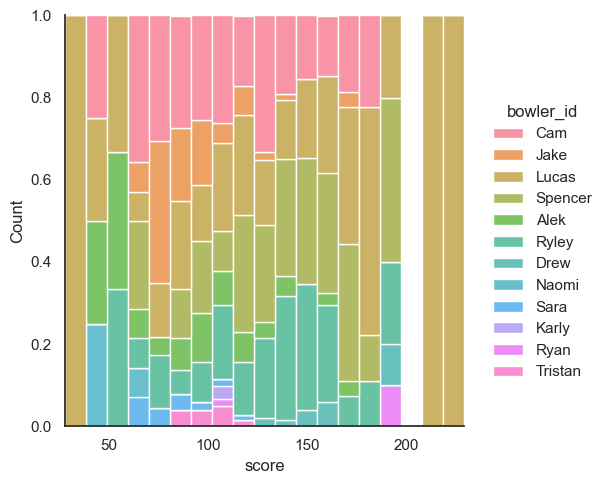

In [6]:
sns.displot(sample_data, x="score", hue="bowler_id", kind="hist", multiple="fill")

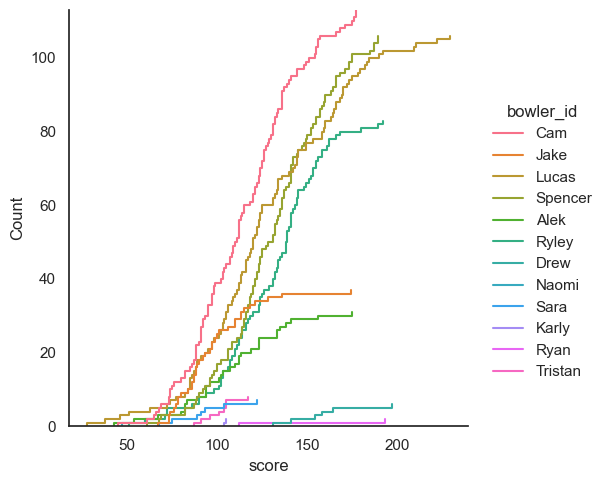

In [7]:
sns.displot(sample_data, x="score", hue="bowler_id", stat="count", kind="ecdf")

#### Score Variance
---

<Axes: xlabel='score', ylabel='bowler_id'>

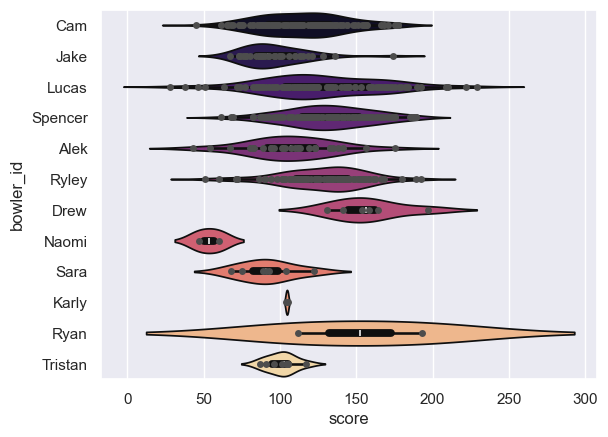

In [8]:
from pinsdb.bowlers import REGISTERED_BOWLERS

palette = sns.color_palette("magma", n_colors=len(REGISTERED_BOWLERS))
sns.set_theme(style="darkgrid", palette=palette)

sns.violinplot(sample_data, x="score", y="bowler_id", hue="bowler_id", palette=palette)
sns.stripplot(sample_data, x="score", y="bowler_id", color=".3", jitter=0)

#### Pins Ordering

In [34]:
heatmap_data = (
    frames_data.select("bowler_id", "game_id", "date", "frames")
    .with_columns(
        pl.col("frames").list.first().alias("first_throw"),
        pl.when(
            (pl.col("frames").list.last() == pl.col("frames").list.first())
            & (pl.col("frames").list.last() == 10)
        )
        .then(pl.lit(0))
        .otherwise(pl.col("frames").list.last())
        .alias("last_throw"),
    )
    .pivot(
        on="last_throw",
        index="first_throw",
        values="last_throw",
        aggregate_function=pl.element().count(),
    )
    .fill_null(0)
    .sort("first_throw")
    .select("first_throw", *map(str, range(11)))
)
heatmap_data

first_throw,0,1,2,3,4,5,6,7,8,9,10
i8,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,111,19,2,32,10,21,45,68,63,64,68
1,28,0,5,10,9,13,28,14,13,11,0
2,3,0,0,0,2,3,1,0,2,0,0
3,49,2,1,19,24,36,26,33,0,0,0
4,17,6,6,13,15,9,19,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…
6,156,57,102,103,110,0,0,0,0,0,0
7,325,127,180,213,0,0,0,0,0,0,0
8,369,197,233,0,0,0,0,0,0,0,0


<Axes: >

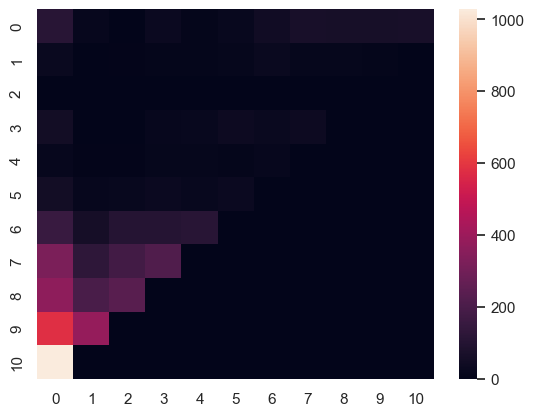

In [36]:
sns.heatmap(heatmap_data.drop("first_throw"))

#### Ridge Graph

#### Score Over Time

In [98]:
bowler_frame.with_columns(pl.col("throws").bowling.compute_score()).sort(
    "score", descending=True
)

game_id,throws,date,bowler_id,score
str,list[i64],date,str,i64
"""1""","[9, 1, … 9]",2025-02-10,"""Lucas""",229
"""2""","[9, 1, … 9]",2025-02-10,"""Lucas""",222
"""2""","[10, 8, … 1]",2025-02-24,"""Lucas""",210
"""1""","[10, 9, … 10]",2025-01-21,"""Lucas""",209
"""2""","[8, 2, … 0]",2024-08-15,"""Drew""",197
…,…,…,…,…
"""1""","[0, 10, … 0]",2024-08-27,"""Lucas""",46
"""4""","[6, 2, … 0]",2024-08-14,"""Cam""",45
"""2""","[0, 0, … 0]",2024-08-06,"""Alek""",43


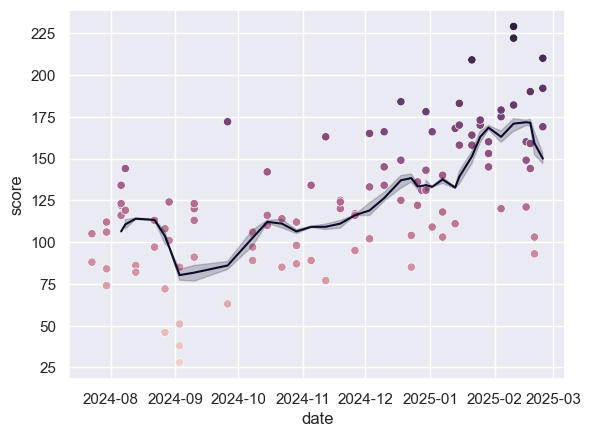

In [95]:
def plot_rolling_mean(data: pl.DataFrame, bowler_id: str, window: int = 10) -> None:
    rolling_mean = (
        bowler_frame.filter(pl.col("bowler_id") == pl.lit(bowler_id))
        .with_columns(pl.col("throws").bowling.compute_score())
        .with_columns(pl.col("score").rolling_mean(window).alias("rolling_mean"))
    )
    ax = sns.scatterplot(
        data=rolling_mean.to_pandas(), x="date", y="score", hue="score"
    )
    sns.lineplot(
        data=rolling_mean.to_pandas(),
        x="date",
        y="rolling_mean",
    )
    ax.get_legend().remove()
    plt.show()


plot_rolling_mean(bowler_frame, bowler_id="Lucas", window=10)